In [1]:
from __future__ import annotations
import json
from pathlib import Path
import numpy as np
import pandas as pd
import sys
from pathlib import Path

def time_to_seconds(time_str: str | None, default_seconds: int = 90 * 60) -> int:
    """
    Convert a SkillCorner time string ("HH:MM:SS") to total seconds.

    Requirements:
        - `time_str` must be either None or a string formatted as "HH:MM:SS".

    Parameters:
        time_str:
            Time string from SkillCorner metadata, e.g. "00:45:12". If None, returns `default_seconds`.
        default_seconds:
            Value to return when `time_str` is None (commonly used as a fallback for missing end_time).

    Returns:
        Total time in seconds as an integer.
    """
    if time_str is None:
        return int(default_seconds)

    h, m, s = map(int, time_str.split(":"))
    return int(h * 3600 + m * 60 + s)

# ------------------------------------------------------------
# Current working directory (use this as a base for saving files if you want)
PROJECT_ROOT: Path = Path.cwd()

# Match configuration
MATCH_ID: int = 1899585
MATCH_DIR: Path = PROJECT_ROOT / "data" / "matches" / str(MATCH_ID)

TRACKING_PATH: Path = MATCH_DIR / f"{MATCH_ID}_tracking_extrapolated.jsonl"
MATCH_META_PATH: Path = MATCH_DIR / f"{MATCH_ID}_match.json"

print("Tracking path:", TRACKING_PATH)
print("Match meta path:", MATCH_META_PATH)

if not TRACKING_PATH.exists():
    raise FileNotFoundError(f"Tracking file not found: {TRACKING_PATH}")
if not MATCH_META_PATH.exists():
    raise FileNotFoundError(f"Match meta file not found: {MATCH_META_PATH}")


# ------------------------------------------------------------
# 1) Load tracking data -> tracking_df
# ------------------------------------------------------------
raw_data = pd.read_json(TRACKING_PATH, lines=True)

tracking_df = pd.json_normalize(
    raw_data.to_dict("records"),
    record_path="player_data",
    meta=["frame", "timestamp", "period", "possession", "ball_data"],
)

# Extract possession fields safely
tracking_df["possession_player_id"] = tracking_df["possession"].apply(lambda x: x.get("player_id"))
tracking_df["possession_group"] = tracking_df["possession"].apply(lambda x: x.get("group"))

# Expand ball_data (optional but commonly useful)
ball_df = pd.json_normalize(tracking_df["ball_data"])
ball_df = ball_df.rename(
    columns={"x": "ball_x", "y": "ball_y", "z": "ball_z", "is_detected": "is_detected_ball"}
)

# If columns already match expected names in your file, this will still work
# (it will just keep those column names if present).
for col in ["ball_x", "ball_y", "ball_z", "is_detected_ball"]:
    if col not in ball_df.columns and col in tracking_df.columns:
        # In case json_normalize already yielded same naming
        pass

tracking_df = pd.concat([tracking_df.drop(columns=["ball_data"]), ball_df], axis=1)

# Drop the nested possession dict now that we extracted fields
tracking_df = tracking_df.drop(columns=["possession"])

# Add match id
tracking_df["match_id"] = MATCH_ID

display(tracking_df.head())


# ------------------------------------------------------------
# 2) Load match metadata -> players_df
# ------------------------------------------------------------
with MATCH_META_PATH.open("r", encoding="utf-8") as f:
    match_meta = json.load(f)

match_meta_df = pd.json_normalize(match_meta, max_level=2)
match_meta_df["home_team_side"] = match_meta_df["home_team_side"].astype(str)

players_df = pd.json_normalize(
    match_meta_df.to_dict("records"),
    record_path="players",
    meta=[
        "home_team_score",
        "away_team_score",
        "date_time",
        "home_team_side",
        "home_team.name",
        "home_team.id",
        "away_team.name",
        "away_team.id",
    ],
)

# Keep only players who played
players_df = players_df[~((players_df["start_time"].isna()) & (players_df["end_time"].isna()))].copy()

# Total time played
players_df["total_time"] = (
    players_df["end_time"].apply(time_to_seconds) - players_df["start_time"].apply(time_to_seconds)
)

# Goalkeeper flag
players_df["is_gk"] = players_df["player_role.acronym"].eq("GK")

# Match name
players_df["match_name"] = players_df["home_team.name"] + " vs " + players_df["away_team.name"]

# Home/Away label
players_df["home_away_player"] = np.where(
    players_df["team_id"].eq(players_df["home_team.id"]),
    "Home",
    "Away",
)

# Team name
players_df["team_name"] = np.where(
    players_df["team_id"].eq(players_df["home_team.id"]),
    players_df["home_team.name"],
    players_df["away_team.name"],
)

# Split home team direction by half
players_df[["home_team_side_1st_half", "home_team_side_2nd_half"]] = (
    players_df["home_team_side"]
    .astype(str)
    .str.strip("[]")
    .str.replace("'", "")
    .str.split(", ", expand=True)
)

# Player direction depends on whether they are home or away
players_df["direction_player_1st_half"] = np.where(
    players_df["home_away_player"].eq("Home"),
    players_df["home_team_side_1st_half"],
    players_df["home_team_side_2nd_half"],
)
players_df["direction_player_2nd_half"] = np.where(
    players_df["home_away_player"].eq("Home"),
    players_df["home_team_side_2nd_half"],
    players_df["home_team_side_1st_half"],
)

# Keep only the columns we want
columns_to_keep = [
    "start_time",
    "end_time",
    "match_name",
    "date_time",
    "home_team.name",
    "away_team.name",
    "id",
    "short_name",
    "number",
    "team_id",
    "team_name",
    "player_role.position_group",
    "total_time",
    "player_role.name",
    "player_role.acronym",
    "is_gk",
    "direction_player_1st_half",
    "direction_player_2nd_half",
]
players_df = players_df[columns_to_keep].copy()

display(players_df.head())


# ------------------------------------------------------------
# 3) Merge -> enriched_tracking_data
# ------------------------------------------------------------
enriched_tracking_data = tracking_df.merge(
    players_df,
    left_on="player_id",
    right_on="id",
    how="left",
    validate="many_to_one",  # best practice: each player_id maps to max 1 row in players_df
)

display(enriched_tracking_data.head())
print("Rows:", len(enriched_tracking_data), "| Cols:", enriched_tracking_data.shape[1])

# ------------------------------------------------------------
# Add Dynamic Events Aggregator to Python path
# ------------------------------------------------------------
AGGREGATOR_DIR = (
    PROJECT_ROOT
    / "resources"
    / "Tutorials"
    / "[Advanced] Aggregating Dynamic Events"
)

sys.path.append(str(AGGREGATOR_DIR))

from DynamicEventsAggregator import DynamicEventAggregator

# ------------------------------------------------------------
# 4) Example: save outputs in the working directory
# ------------------------------------------------------------
output_path = PROJECT_ROOT / f"{MATCH_ID}_enriched_tracking.parquet"
#enriched_tracking_data.to_parquet(output_path, index=False)
#print("Saved:", output_path)


Tracking path: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\opendata\data\matches\1899585\1899585_tracking_extrapolated.jsonl
Match meta path: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\opendata\data\matches\1899585\1899585_match.json


,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id
0,-39.61,0.71,34718,False,10,2025-12-17,1.0,23909.0,away team,0.73,-0.93,0.26,True,1899585
1,-18.99,10.85,698137,True,10,2025-12-17,1.0,23909.0,away team,0.73,-0.93,0.26,True,1899585
2,-17.05,-11.54,799092,True,10,2025-12-17,1.0,23909.0,away team,0.73,-0.93,0.26,True,1899585
3,-20.05,1.28,42510,True,10,2025-12-17,1.0,23909.0,away team,0.73,-0.93,0.26,True,1899585
4,-1.41,-30.06,51017,True,10,2025-12-17,1.0,23909.0,away team,0.73,-0.93,0.26,True,1899585


,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,01:34:37,None,Auckland FC vs Wellington Phoenix FC,2024-12-07T04:00:00Z,Auckland FC,Wellington Phoenix FC,957734,C. Piper,3,867,Wellington Phoenix FC,Full Back,-277,Left Wing Back,LWB,False,left_to_right,right_to_left
1,00:00:00,01:19:45,Auckland FC vs Wellington Phoenix FC,2024-12-07T04:00:00Z,Auckland FC,Wellington Phoenix FC,27003,K. Nagasawa,25,867,Wellington Phoenix FC,Center Forward,4785,Center Forward,CF,False,left_to_right,right_to_left
2,00:00:00,00:21:41,Auckland FC vs Wellington Phoenix FC,2024-12-07T04:00:00Z,Auckland FC,Wellington Phoenix FC,14736,L. Verstraete,6,4177,Auckland FC,Midfield,1301,Right Midfield,RM,False,right_to_left,left_to_right
3,01:00:10,None,Auckland FC vs Wellington Phoenix FC,2024-12-07T04:00:00Z,Auckland FC,Wellington Phoenix FC,6799,M. Rojas,21,867,Wellington Phoenix FC,Center Forward,1790,Center Forward,CF,False,left_to_right,right_to_left
4,00:58:04,None,Auckland FC vs Wellington Phoenix FC,2024-12-07T04:00:00Z,Auckland FC,Wellington Phoenix FC,965684,L. Toomey,8,4177,Auckland FC,Wide Attacker,1916,Left Winger,LW,False,right_to_left,left_to_right


,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,-39.61,0.71,34718,False,10,2025-12-17,1.0,23909.0,away team,0.73,...,1,867,Wellington Phoenix FC,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
1,-18.99,10.85,698137,True,10,2025-12-17,1.0,23909.0,away team,0.73,...,15,867,Wellington Phoenix FC,Central Defender,5400,Center Back,CB,False,left_to_right,right_to_left
2,-17.05,-11.54,799092,True,10,2025-12-17,1.0,23909.0,away team,0.73,...,27,867,Wellington Phoenix FC,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left
3,-20.05,1.28,42510,True,10,2025-12-17,1.0,23909.0,away team,0.73,...,4,867,Wellington Phoenix FC,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
4,-1.41,-30.06,51017,True,10,2025-12-17,1.0,23909.0,away team,0.73,...,6,867,Wellington Phoenix FC,Full Back,3610,Right Wing Back,RWB,False,left_to_right,right_to_left


Rows: 894982 | Cols: 32


In [2]:
whos

Variable                 Type             Data/Info
---------------------------------------------------
AGGREGATOR_DIR           WindowsPath      C:\Users\henri\Desktop\Fo<...>ggregating Dynamic Events
DynamicEventAggregator   type             <class 'DynamicEventsAggr<...>.DynamicEventAggregator'>
MATCH_DIR                WindowsPath      C:\Users\henri\Desktop\Fo<...>data\data\matches\1899585
MATCH_ID                 int              1899585
MATCH_META_PATH          WindowsPath      C:\Users\henri\Desktop\Fo<...>899585\1899585_match.json
PROJECT_ROOT             WindowsPath      C:\Users\henri\Desktop\Fo<...>er\Ball\projects\opendata
Path                     type             <class 'pathlib.Path'>
TRACKING_PATH            WindowsPath      C:\Users\henri\Desktop\Fo<...>acking_extrapolated.jsonl
annotations              _Feature         _Feature((3, 7, 0, 'beta', 1), None, 16777216)
ball_df                  DataFrame        Shape: (894982, 4)
col                      str              i

In [3]:
enriched_tracking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894982 entries, 0 to 894981
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   x                           894982 non-null  float64       
 1   y                           894982 non-null  float64       
 2   player_id                   894982 non-null  int64         
 3   is_detected                 894982 non-null  bool          
 4   frame                       894982 non-null  object        
 5   timestamp                   894982 non-null  datetime64[ns]
 6   period                      894982 non-null  object        
 7   possession_player_id        197076 non-null  float64       
 8   possession_group            634656 non-null  object        
 9   ball_x                      894982 non-null  float64       
 10  ball_y                      894982 non-null  float64       
 11  ball_z                      894982 non-

In [4]:
HOME_TEAM_ID: int = int(match_meta_df.loc[0, "home_team.id"])
AWAY_TEAM_ID: int = int(match_meta_df.loc[0, "away_team.id"])

# Global team color mapping (adjust colors as you like)
TEAM_COLORS: dict[int, str] = {
    HOME_TEAM_ID: "blue",
    AWAY_TEAM_ID: "red",
}

# Goalkeeper color (used in plotting)
GK_COLOR: str = "green"

print("Home team ID:", HOME_TEAM_ID)
print("Away team ID:", AWAY_TEAM_ID)

Home team ID: 4177
Away team ID: 867


In [5]:
# Sanity checks
print("Rows:", len(enriched_tracking_data))
print("Unique frames:", enriched_tracking_data["frame"].nunique())
print("Unique players:", enriched_tracking_data["player_id"].nunique())

Rows: 894982
Unique frames: 40681
Unique players: 30


In [6]:
# Basic coordinate sanity check ---
print("x range:", enriched_tracking_data["x"].min(), "to", enriched_tracking_data["x"].max())
print("y range:", enriched_tracking_data["y"].min(), "to", enriched_tracking_data["y"].max())

print("ball_x range:", enriched_tracking_data["ball_x"].min(), "to", enriched_tracking_data["ball_x"].max())
print("ball_y range:", enriched_tracking_data["ball_y"].min(), "to", enriched_tracking_data["ball_y"].max())

x range: -57.6 to 56.03
y range: -38.0 to 37.5
ball_x range: -58.31 to 57.04
ball_y range: -38.62 to 39.16


In [7]:
enriched_tracking_data["is_gk"].value_counts()

is_gk
False    813620
True      81362
Name: count, dtype: int64

In [8]:
from __future__ import annotations
import pandas as pd

def match_context(match_meta_df: pd.DataFrame) -> dict[str, str | int]:
    """
    Extract basic match context (teams and score) from SkillCorner match metadata.

    Requirements:
        - match_meta_df must be a DataFrame created via pd.json_normalize(match_meta, max_level=2)
        - must contain exactly one row
        - required cols: home_team.name, away_team.name, home_team_score, away_team_score
    """
    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row (one match).")

    required = {"home_team.name", "away_team.name", "home_team_score", "away_team_score"}
    missing = required.difference(match_meta_df.columns)
    if missing:
        raise KeyError(f"Missing required columns in match_meta_df: {sorted(missing)}")

    row = match_meta_df.iloc[0]

    home_team = str(row["home_team.name"])
    away_team = str(row["away_team.name"])
    home_score = int(row["home_team_score"])
    away_score = int(row["away_team_score"])

    return {
        "home_team": home_team,
        "away_team": away_team,
        "home_score": home_score,
        "away_score": away_score,
        "scoreline": f"{home_score}–{away_score}",
        "match_label": f"{home_team} {home_score}–{away_score} {away_team}",
    }


In [9]:
from __future__ import annotations

from typing import Set
import pandas as pd


def normalize_tracking_direction(
    tracking_df: pd.DataFrame,
    *,
    home_team_id: int,
    flip_y: bool = True,
) -> pd.DataFrame:
    """
    Normalize tracking so HOME always attacks left->right for the full match.

    Strategy:
      - Build a frame-level flip mask using HOME rows only (direction flags)
      - Flip ALL rows (both teams) in those frames to preserve geometry
      - Flip ball in the same frames
    """
    df = tracking_df.copy()

    required: Set[str] = {
        "frame", "period", "team_id",
        "x", "y", "ball_x", "ball_y",
        "direction_player_1st_half", "direction_player_2nd_half",
    }
    missing = required.difference(df.columns)
    if missing:
        raise KeyError(f"Missing required tracking columns: {sorted(missing)}")

    home = df.loc[
        df["team_id"].eq(home_team_id),
        ["frame", "period", "direction_player_1st_half", "direction_player_2nd_half"]
    ].copy()

    if home.empty:
        raise ValueError("No home-team rows found (check home_team_id vs team_id).")

    def needs_flip(period: float, d1: str, d2: str) -> bool:
        p = int(period)
        if p == 1:
            return str(d1) == "right_to_left"
        if p == 2:
            return str(d2) == "right_to_left"
        return False

    home["needs_flip"] = home.apply(
        lambda r: needs_flip(r["period"], r["direction_player_1st_half"], r["direction_player_2nd_half"]),
        axis=1,
    )
    flip_by_frame = home.groupby("frame")["needs_flip"].any()
    flip_mask = df["frame"].map(flip_by_frame).fillna(False)

    df.loc[flip_mask, "x"] = -df.loc[flip_mask, "x"]
    df.loc[flip_mask, "ball_x"] = -df.loc[flip_mask, "ball_x"]

    if flip_y:
        df.loc[flip_mask, "y"] = -df.loc[flip_mask, "y"]
        df.loc[flip_mask, "ball_y"] = -df.loc[flip_mask, "ball_y"]

    return df

In [10]:
import pandas as pd

# --- Load dynamic events file ---
de_path = f"data/matches/{MATCH_ID}/{MATCH_ID}_dynamic_events.csv"
de = pd.read_csv(de_path)

# --- Quick look ---
print("Rows:", len(de))
print("Columns:", de.columns.tolist())
de = de.sort_values("index").reset_index(drop=True)
de.head()

Rows: 4713
Columns: ['event_id', 'index', 'match_id', 'frame_start', 'frame_end', 'frame_physical_start', 'time_start', 'time_end', 'minute_start', 'second_start', 'duration', 'period', 'attacking_side_id', 'attacking_side', 'event_type_id', 'event_type', 'event_subtype_id', 'event_subtype', 'player_id', 'player_name', 'player_position_id', 'player_position', 'player_in_possession_id', 'player_in_possession_name', 'player_in_possession_position_id', 'player_in_possession_position', 'team_id', 'team_shortname', 'x_start', 'y_start', 'channel_id_start', 'channel_start', 'third_id_start', 'third_start', 'penalty_area_start', 'x_end', 'y_end', 'channel_id_end', 'channel_end', 'third_id_end', 'third_end', 'penalty_area_end', 'associated_player_possession_event_id', 'associated_player_possession_frame_start', 'associated_player_possession_frame_end', 'associated_player_possession_end_type_id', 'associated_player_possession_end_type', 'associated_off_ball_run_event_id', 'associated_off_ball_r

C:\Users\henri\AppData\Local\Temp\ipykernel_18816\4032140451.py:5: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  de = pd.read_csv(de_path)


,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,...,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated
0,8_0,0,1899585,12,12,NaN,00:00.2,00:00.2,0,0,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False
1,8_1,1,1899585,31,44,NaN,00:02.1,00:03.4,0,2,...,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False
2,7_0,2,1899585,31,32,NaN,00:02.1,00:02.2,0,2,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
3,7_1,3,1899585,31,44,NaN,00:02.1,00:03.4,0,2,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
4,9_0,4,1899585,37,44,17.0,00:00.7,00:03.4,0,0,...,NaN,NaN,NaN,NaN,NaN,True,True,True,True,NaN


In [11]:
from __future__ import annotations

from typing import List
import pandas as pd


def get_home_team_sides(match_meta_df: pd.DataFrame) -> tuple[str, str]:
    """
    Returns (home_dir_p1, home_dir_p2) as 'left_to_right' / 'right_to_left'
    from match metadata.
    """
    if len(match_meta_df) != 1:
        raise ValueError("match_meta_df must contain exactly one row.")
    if "home_team_side" not in match_meta_df.columns:
        raise KeyError("match_meta_df must contain 'home_team_side'.")

    raw = str(match_meta_df.loc[0, "home_team_side"])  # e.g. "['right_to_left', 'left_to_right']"
    cleaned = raw.strip("[]").replace("'", "")
    parts = [p.strip() for p in cleaned.split(",") if p.strip()]
    if len(parts) < 2:
        raise ValueError(f"Could not parse home_team_side into two halves: {raw}")
    return parts[0], parts[1]


def normalize_dynamic_events_to_home_ltr(
    de: pd.DataFrame,
    *,
    home_dir_p1: str,
    home_dir_p2: str,
    flip_y: bool = True,
) -> pd.DataFrame:
    """
    Normalize Dynamic Events coordinates into the SAME coordinate system as `enriched_tracking_norm`
    (HOME always left->right).

    Steps:
      A) Convert DE coordinates from "possession-LTR" to "pitch" using attacking_side:
         - if attacking_side == 'right_to_left' -> un-mirror: x,y *= -1
      B) Apply match-level flip (same as tracking normalization) based on home_dir per period:
         - if home_dir in that period was right_to_left -> flip entire period: x,y *= -1
    """
    df = de.copy()

    if "period" not in df.columns:
        raise KeyError("Dynamic events df must contain 'period'.")
    if "attacking_side" not in df.columns:
        raise KeyError("Dynamic events df must contain 'attacking_side' (needed to un-mirror).")

    # --- coordinate columns to flip ---
    x_cols: List[str] = [
        c for c in df.columns
        if c in {"x_start", "x_end", "x"} or c.endswith("_x_start") or c.endswith("_x_end") or c.endswith("_x_reception")
    ]
    y_cols: List[str] = [
        c for c in df.columns
        if c in {"y_start", "y_end", "y"} or c.endswith("_y_start") or c.endswith("_y_end") or c.endswith("_y_reception")
    ]
    x_cols = [c for c in x_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
    y_cols = [c for c in y_cols if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

    # A) Un-mirror using attacking_side (because DE coords are delivered as if possession attacks LTR)
    unmirror_mask = df["attacking_side"].astype(str).eq("right_to_left")
    if x_cols:
        df.loc[unmirror_mask, x_cols] = -df.loc[unmirror_mask, x_cols]
    if flip_y and y_cols:
        df.loc[unmirror_mask, y_cols] = -df.loc[unmirror_mask, y_cols]

    # B) Match-level flip to enforce "HOME always LTR" across halves
    flip_p1 = (home_dir_p1 == "right_to_left")
    flip_p2 = (home_dir_p2 == "right_to_left")
    match_flip_mask = (df["period"].eq(1) & flip_p1) | (df["period"].eq(2) & flip_p2)

    if x_cols:
        df.loc[match_flip_mask, x_cols] = -df.loc[match_flip_mask, x_cols]
    if flip_y and y_cols:
        df.loc[match_flip_mask, y_cols] = -df.loc[match_flip_mask, y_cols]

    return df


home_dir_p1, home_dir_p2 = get_home_team_sides(match_meta_df)

enriched_tracking_norm = normalize_tracking_direction(
    enriched_tracking_data,
    home_team_id=HOME_TEAM_ID,
    flip_y=True,
)

de_norm = normalize_dynamic_events_to_home_ltr(
    de,
    home_dir_p1=home_dir_p1,
    home_dir_p2=home_dir_p2,
    flip_y=True,
)


In [12]:
import math
import pandas as pd

# This function checks the distance between player in possession and ball. Distance should be short. 
def ball_pass_start_distance(
    tracking_norm: pd.DataFrame,
    *,
    frame: int,
    pass_x_start: float,
    pass_y_start: float,
) -> float:
    snap = tracking_norm.loc[tracking_norm["frame"].eq(int(frame))]
    if snap.empty:
        raise ValueError(f"No tracking rows for frame={frame}")

    bx = float(snap["ball_x"].iloc[0])
    by = float(snap["ball_y"].iloc[0])

    return math.hypot(bx - float(pass_x_start), by - float(pass_y_start))


In [13]:
from __future__ import annotations

import numpy as np
import pandas as pd


def add_player_speed_direction(
    tracking_df: pd.DataFrame,
    *,
    fps: float = 10.0,
    x_col: str = "x",
    y_col: str = "y",
    group_col: str = "player_id",
    frame_col: str = "frame",
) -> pd.DataFrame:
    """
    Add per-frame player movement features: dx, dy, speed (m/s), vx, vy, angle_rad, angle_deg.

    Requirements:
        - tracking_df contains: [group_col, frame_col, x_col, y_col]
        - coordinates are in meters (SkillCorner skillcorner pitch coords)

    Notes:
        - Uses simple frame-to-frame differencing (no smoothing).
        - speed is computed per player across the full match timeline.
        - First frame per player => dx/dy/speed will be NaN (filled with 0 by default below).

    Returns:
        Copy of tracking_df with new columns:
            dx, dy, vx, vy, speed, angle_rad, angle_deg
    """
    required = {group_col, frame_col, x_col, y_col}
    missing = required.difference(tracking_df.columns)
    if missing:
        raise KeyError(f"Missing required tracking columns: {sorted(missing)}")

    df = tracking_df.copy()
    df = df.sort_values([group_col, frame_col], kind="mergesort")

    df["dx"] = df.groupby(group_col, sort=False)[x_col].diff()
    df["dy"] = df.groupby(group_col, sort=False)[y_col].diff()

    # Velocities in m/s
    df["vx"] = df["dx"] * float(fps)
    df["vy"] = df["dy"] * float(fps)

    # Speed magnitude
    df["speed"] = np.sqrt(df["vx"] ** 2 + df["vy"] ** 2)

    # Direction (movement angle) in radians/degrees, based on vx/vy
    df["angle_rad"] = np.arctan2(df["vy"], df["vx"])
    df["angle_deg"] = np.degrees(df["angle_rad"])

    # Optional: replace NaNs (first frame per player) with 0.0
    for c in ["dx", "dy", "vx", "vy", "speed", "angle_rad", "angle_deg"]:
        df[c] = df[c].fillna(0.0)

    return df


enriched_tracking_norm = add_player_speed_direction(enriched_tracking_norm, fps=10.0)

In [14]:
# --- Event types and subtypes ---
de_norm["event_type"].value_counts()

event_type
passing_option        2387
player_possession      929
on_ball_engagement     929
off_ball_run           468
Name: count, dtype: int64

In [15]:
de_norm["event_subtype"].value_counts()

event_subtype
pressure                 269
other                    226
recovery_press           195
pressing                 140
run_ahead_of_the_ball    125
counter_press             99
support                   89
coming_short              54
dropping_off              47
cross_receiver            46
behind                    31
pulling_wide              30
overlap                   24
underlap                  12
pulling_half_space        10
Name: count, dtype: int64

In [16]:
de_norm.head()

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,...,xloss_player_possession_end,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated
0,8_0,0,1899585,12,12,NaN,00:00.2,00:00.2,0,0,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,False
1,8_1,1,1899585,31,44,NaN,00:02.1,00:03.4,0,2,...,NaN,NaN,NaN,NaN,NaN,True,True,True,True,False
2,7_0,2,1899585,31,32,NaN,00:02.1,00:02.2,0,2,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
3,7_1,3,1899585,31,44,NaN,00:02.1,00:03.4,0,2,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,False
4,9_0,4,1899585,37,44,17.0,00:00.7,00:03.4,0,0,...,NaN,NaN,NaN,NaN,NaN,True,True,True,True,NaN


In [17]:
goals_by_interrupt = de_norm[
    (de_norm["event_type"] == "player_possession") &
    (de_norm["game_interruption_after"].isin(["goal_for", "goal_against"]))
].sort_values(["index"])

goals_by_interrupt[["index","event_id","team_shortname","game_interruption_after","frame_start","frame_end","time_start","time_end","end_type"]].head(10)

,index,event_id,team_shortname,game_interruption_after,frame_start,frame_end,time_start,time_end,end_type
1462,1462,8_302,Auckland FC,goal_for,18150,18164,30:14.0,30:15.4,pass
3532,3532,8_690,Auckland FC,goal_for,44380,44380,69:21.0,69:21.0,shot
4037,4037,8_797,Wellington P FC,goal_for,51899,51899,81:52.9,81:52.9,shot


In [18]:
from typing import Iterable
import numpy as np
import pandas as pd
from __future__ import annotations
from typing import Iterable



def _require_columns(df: pd.DataFrame, required: Iterable[str]) -> None:
    """Validate that required columns exist in the DataFrame."""
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")


def get_all_goal_events(de_norm: pd.DataFrame) -> pd.DataFrame:
    """
    Return ALL goal events (sorted) from normalized dynamic events.

    A "goal event" is a player_possession with game_interruption_after in ['goal_for','goal_against'].
    """
    _require_columns(de_norm, ["event_type", "game_interruption_after", "frame_start", "index", "event_id"])

    goals = de_norm.loc[
        (de_norm["event_type"] == "player_possession")
        & (de_norm["game_interruption_after"].isin(["goal_for", "goal_against"]))
    ].copy()

    if goals.empty:
        raise ValueError("No goal events found (game_interruption_after in ['goal_for','goal_against']).")

    goals = goals.sort_values(["frame_start", "index"], ascending=True).reset_index(drop=True)
    return goals


def find_last_completed_pass_before_frame(
    de_norm: pd.DataFrame,
    cutoff_frame: int,
    *,
    pass_event_types: tuple[str, ...] = ("player_possession",),
) -> pd.Series:
    """
    Find the last completed pass event before a given cutoff frame in normalized dynamic events.
    """
    _require_columns(de_norm, ["event_type", "frame_start", "frame_end", "index"])

    candidates = de_norm.loc[
        (de_norm["event_type"].isin(pass_event_types))
        & (de_norm["frame_end"] < int(cutoff_frame))
    ].copy()

    if "end_type" in candidates.columns:
        candidates = candidates.loc[candidates["end_type"] == "pass"]

    if candidates.empty:
        raise ValueError("No pass candidates found before cutoff_frame with the given filters.")

    if "pass_outcome" in candidates.columns:
        candidates = candidates.loc[candidates["pass_outcome"] == "successful"]

    if candidates.empty:
        raise ValueError("No completed pass found before cutoff_frame (pass_outcome filtering removed all rows).")

    candidates = candidates.sort_values(["frame_end", "index"], ascending=True)
    return candidates.iloc[-1]


def _get_pass_moment_frame_from_passing_option(
    de_norm: pd.DataFrame,
    player_possession_row: pd.Series,
) -> int:
    """
    Infer the 'true' pass frame for a player_possession ending with a pass.
    """
    fallback_frame = int(player_possession_row["frame_end"])

    po_id = player_possession_row.get("targeted_passing_option_event_id", None)
    if pd.isna(po_id) or po_id is None:
        return fallback_frame

    po_rows = de_norm.loc[
        (de_norm["event_type"] == "passing_option") & (de_norm["event_id"] == po_id)
    ]
    if po_rows.empty:
        return fallback_frame

    po = po_rows.iloc[0]
    if "peak_passing_option_frame" in po.index and pd.notna(po["peak_passing_option_frame"]):
        return int(po["peak_passing_option_frame"])

    return fallback_frame


def _extract_pass_coordinates(row: pd.Series) -> dict[str, float]:
    """
    Extract pass start/end coordinates from the pass event row (already normalized).
    """
    def _get_float(*cols: str) -> float:
        for col in cols:
            if col in row.index and pd.notna(row[col]):
                return float(row[col])
        return float("nan")

    return {
        "pass_x_start": _get_float("player_in_possession_x_end", "x_end"),
        "pass_y_start": _get_float("player_in_possession_y_end", "y_end"),
        "pass_x_end": _get_float("player_targeted_x_reception"),
        "pass_y_end": _get_float("player_targeted_y_reception"),
    }


def get_last_completed_pass_before_all_goals(de_norm: pd.DataFrame) -> pd.DataFrame:
    """
    Return a DataFrame with one row per goal:
      - the last completed pass before that goal
      - pass_moment_frame
      - pass start/end coordinates

    Output columns include the same pass columns as before, plus some goal context
    (goal_event_id, goal_frame_start, goal_index, goal_team_shortname if available).
    """
    goals = get_all_goal_events(de_norm)

    pass_cols = [
        "event_id",
        "event_type",
        "index",
        "player_id",
        "frame_start",
        "frame_end",
        "passing_option_at_pass_moment",
        "player_targeted_xpass_completion",
        "n_simultaneous_passing_options",
        "player_targeted_difficult_pass_target",
        "player_targeted_xthreat",
        "xpass_completion",
        "passing_option_score",
        "targeted_passing_option_event_id",
    ]

    out_rows: list[dict] = []

    for _, goal_row in goals.iterrows():
        cutoff_frame = int(goal_row["frame_start"])

        try:
            last_pass_pp = find_last_completed_pass_before_frame(de_norm, cutoff_frame)
        except ValueError:
            # If no pass exists before this goal (rare, but possible), still output a row with NaNs
            base = {c: np.nan for c in pass_cols}
            base.update(
                {
                    "pass_moment_frame": np.nan,
                    "pass_x_start": np.nan,
                    "pass_y_start": np.nan,
                    "pass_x_end": np.nan,
                    "pass_y_end": np.nan,
                }
            )
            base["goal_event_id"] = goal_row.get("event_id", np.nan)
            base["goal_frame_start"] = cutoff_frame
            base["goal_index"] = goal_row.get("index", np.nan)
            if "team_shortname" in goals.columns:
                base["goal_team_shortname"] = goal_row.get("team_shortname", np.nan)
            out_rows.append(base)
            continue

        pass_moment_frame = _get_pass_moment_frame_from_passing_option(de_norm, last_pass_pp)
        coords = _extract_pass_coordinates(last_pass_pp)

        row_out = {c: (last_pass_pp[c] if c in last_pass_pp.index else np.nan) for c in pass_cols}
        row_out["pass_moment_frame"] = int(pass_moment_frame)
        row_out.update(coords)

        # Goal context (useful downstream)
        row_out["goal_event_id"] = goal_row.get("event_id", np.nan)
        row_out["goal_frame_start"] = int(goal_row["frame_start"])
        row_out["goal_index"] = goal_row.get("index", np.nan)
        if "team_shortname" in goals.columns:
            row_out["goal_team_shortname"] = goal_row.get("team_shortname", np.nan)

        out_rows.append(row_out)

    result = pd.DataFrame(out_rows)

    # Nice ordering: by goal time
    sort_cols = [c for c in ["goal_frame_start", "goal_index"] if c in result.columns]
    if sort_cols:
        result = result.sort_values(sort_cols).reset_index(drop=True)

    return result



In [19]:
result = get_last_completed_pass_before_all_goals(de_norm)
display(result)
print("Rows (goals):", len(result))
SELECTED_FRAME = int(result.loc[0, "pass_moment_frame"])
print("SELECTED_FRAME (pass moment):", SELECTED_FRAME)

,event_id,event_type,index,player_id,frame_start,frame_end,passing_option_at_pass_moment,player_targeted_xpass_completion,n_simultaneous_passing_options,player_targeted_difficult_pass_target,...,targeted_passing_option_event_id,pass_moment_frame,pass_x_start,pass_y_start,pass_x_end,pass_y_end,goal_event_id,goal_frame_start,goal_index,goal_team_shortname
0,8_301,player_possession,1454,50951,18118,18136,NaN,0.5503,NaN,True,...,7_740,18136,27.55,-25.33,40.32,-16.25,8_302,18150,1462,Auckland FC
1,8_688,player_possession,3525,50951,43471,43476,NaN,0.9466,NaN,False,...,7_1775,43476,3.98,-21.83,7.15,-29.33,8_690,44380,3532,Auckland FC
2,8_796,player_possession,4028,51015,51849,51872,NaN,0.3655,NaN,True,...,7_2044,51872,-9.66,-16.51,-37.49,-9.10,8_797,51899,4037,Wellington P FC


Rows (goals): 3
SELECTED_FRAME (pass moment): 18136


In [20]:
result = get_last_completed_pass_before_all_goals(de_norm)
row = result.loc[0]

dist = ball_pass_start_distance(
    enriched_tracking_norm,
    frame=int(row["pass_moment_frame"]),
    pass_x_start=float(row["pass_x_start"]),
    pass_y_start=float(row["pass_y_start"]),
)
print("Ball–pass_start distance (m):", dist)

Ball–pass_start distance (m): 1.3059862173851606


In [21]:
from __future__ import annotations

from pathlib import Path
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch


def create_pitch_axes(
    *,
    pitch_length: float = 105.0,
    pitch_width: float = 68.0,
    pitch_type: str = "skillcorner",
    figsize: tuple[int, int] = (10, 7),
) -> Tuple[plt.Figure, plt.Axes]:
    pitch = Pitch(pitch_type=pitch_type, pitch_length=pitch_length, pitch_width=pitch_width)
    fig, ax = pitch.draw(figsize=figsize)
    return fig, ax


def plot_tracking_frame(
    tracking_df: pd.DataFrame,
    selected_frame: int,
    team_colors: dict[int, str],
    *,
    pitch_length: float = 105.0,
    pitch_width: float = 68.0,
    player_size: float = 120,
    ball_size: float = 90,
    gk_size: float = 120,
    gk_color: str = "gold",
    highlight_player_id: int | None = None,
    highlight_size: float = 140,
    number_dx: float = 1.1,
    number_dy: float = 1.1,
    show_numbers: bool = True,
    show_ball: bool = True,
    title_prefix: str | None = None,
    # --- Pass arrow ---
    ARROW: bool = True,
    pass_x_start: float | None = None,
    pass_y_start: float | None = None,
    pass_x_end: float | None = None,
    pass_y_end: float | None = None,
    # --- Movement (speed + direction) ---
    SHOW_MOVEMENT: bool = True,
    movement_scale: float = 0.25,  # multiplies vx/vy to convert "m/s" to "meters on plot"
    movement_min_speed: float = 0.5,  # m/s threshold to draw arrows
    # Optional labels
    SHOW_SPEED_LABELS: bool = False,
    speed_fontsize: int = 7,
    # --- Saving ---
    WORKING_DIR: Path | None = None,
    SAVE: bool = False,
    save_name: str | None = None,
    dpi: int = 200,
    match_label: str | None = None,
    # --- Debug / sanity ---
    sanity_check: bool = True,
    sanity_tol: float = 15.0,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot a single frame from normalized SkillCorner tracking, optionally:
      - pass arrow
      - player movement arrows based on vx/vy + speed (must exist in df)

    Requirements for movement arrows (if SHOW_MOVEMENT=True):
        - tracking_df must include: ['vx','vy','speed'] (use add_player_speed_direction first)
    """
    required_cols = {"frame", "x", "y", "team_id", "player_id", "is_gk"}
    missing = required_cols.difference(tracking_df.columns)
    if missing:
        raise KeyError(f"Tracking dataframe is missing required columns: {sorted(missing)}")

    snap = tracking_df.loc[tracking_df["frame"] == int(selected_frame)].copy()
    if snap.empty:
        raise ValueError(f"No tracking rows found for frame={selected_frame}")

    if SHOW_MOVEMENT:
        needed = {"vx", "vy", "speed"}
        miss2 = needed.difference(snap.columns)
        if miss2:
            raise KeyError(
                f"SHOW_MOVEMENT=True requires columns {sorted(needed)}. "
                "Run add_player_speed_direction(enriched_tracking_norm) first."
            )

    fig, ax = create_pitch_axes(
        pitch_length=pitch_length,
        pitch_width=pitch_width,
        pitch_type="skillcorner",
        figsize=(10, 7),
    )

    # --- Outfield players by team ---
    for team_id, color in team_colors.items():
        outfield = snap.loc[(snap["team_id"] == team_id) & (~snap["is_gk"])]

        ax.scatter(
            outfield["x"],
            outfield["y"],
            s=player_size,
            color=color,
            edgecolors="black",
            linewidth=0.5,
            alpha=0.9,
            zorder=3,
        )

        # Movement arrows (same color as team)
        if SHOW_MOVEMENT and not outfield.empty:
            moving = outfield.loc[outfield["speed"] >= float(movement_min_speed)].copy()
            if not moving.empty:
                ax.quiver(
                    moving["x"].astype(float),
                    moving["y"].astype(float),
                    (moving["vx"].astype(float) * float(movement_scale)),
                    (moving["vy"].astype(float) * float(movement_scale)),
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    width=0.002,
                    headwidth=2,
                    headlength=4,
                    headaxislength=3.5,
                    color=color,
                    alpha=0.9,
                    zorder=8,
                )

            if SHOW_SPEED_LABELS:
                for _, r in moving.iterrows():
                    ax.text(
                        float(r["x"]) - number_dx,
                        float(r["y"]) - number_dy,
                        f"{float(r['speed']):.1f}",
                        color=color,
                        fontsize=int(speed_fontsize),
                        ha="center",
                        va="center",
                        zorder=9,
                    )

        # Jersey numbers (same color as team)
        if show_numbers and "number" in outfield.columns:
            for _, r in outfield.iterrows():
                if pd.isna(r["number"]):
                    continue
                ax.text(
                    float(r["x"]) + number_dx,
                    float(r["y"]) + number_dy,
                    str(int(r["number"])),
                    color=color,
                    fontsize=8,
                    ha="center",
                    va="center",
                    zorder=7,
                )

    # --- Goalkeepers ---
    gks = snap.loc[snap["is_gk"]]
    if not gks.empty:
        ax.scatter(
            gks["x"],
            gks["y"],
            s=gk_size,
            color=gk_color,
            edgecolors="black",
            linewidth=1.0,
            alpha=1.0,
            zorder=4,
        )

        # GK movement arrows (use GK color)
        if SHOW_MOVEMENT:
            gk_moving = gks.loc[gks["speed"] >= float(movement_min_speed)].copy()
            if not gk_moving.empty:
                ax.quiver(
                    gk_moving["x"].astype(float),
                    gk_moving["y"].astype(float),
                    (gk_moving["vx"].astype(float) * float(movement_scale)),
                    (gk_moving["vy"].astype(float) * float(movement_scale)),
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    width=0.003,
                    headwidth=3,
                    headlength=4,
                    headaxislength=3.5,
                    color=gk_color,
                    alpha=0.9,
                    zorder=8,
                )

        # GK numbers in GK color
        if show_numbers and "number" in gks.columns:
            for _, r in gks.iterrows():
                if pd.isna(r["number"]):
                    continue
                ax.text(
                    float(r["x"]) + number_dx,
                    float(r["y"]) + number_dy,
                    str(int(r["number"])),
                    color=gk_color,
                    fontsize=8,
                    ha="center",
                    va="center",
                    zorder=7,
                )

    # Highlight player (optional)
    if highlight_player_id is not None:
        h = snap.loc[snap["player_id"] == int(highlight_player_id)]
        if not h.empty:
            ax.scatter(
                h["x"],
                h["y"],
                s=highlight_size,
                facecolors="none",
                edgecolors="blue",
                linewidth=3.0,
                zorder=6,
            )

    # Ball (optional)
    ball_xy = None
    if show_ball and {"ball_x", "ball_y"}.issubset(snap.columns):
        bx = snap["ball_x"].iloc[0]
        by = snap["ball_y"].iloc[0]
        if pd.notna(bx) and pd.notna(by):
            ball_xy = (float(bx), float(by))
            ax.scatter(ball_xy[0], ball_xy[1], s=ball_size, color="black", zorder=5)

    # Pass arrow (optional) - keep black (as you had)
    if ARROW:
        coords = [pass_x_start, pass_y_start, pass_x_end, pass_y_end]
        if any(v is None for v in coords):
            raise ValueError("ARROW=True requires pass_x_start, pass_y_start, pass_x_end, pass_y_end.")

        if all(pd.notna(v) for v in coords):
            ax.annotate(
                "",
                xy=(float(pass_x_end), float(pass_y_end)),
                xytext=(float(pass_x_start), float(pass_y_start)),
                arrowprops=dict(arrowstyle="->", color="black", lw=0.9),
                zorder=10,
            )

            if sanity_check and ball_xy is not None:
                dx = ball_xy[0] - float(pass_x_start)
                dy = ball_xy[1] - float(pass_y_start)
                dist = (dx * dx + dy * dy) ** 0.5
                if dist > float(sanity_tol):
                    print(
                        f"[WARN] Ball is {dist:.1f}m from pass start at frame={selected_frame}."
                    )

    # Title
    parts = []
    if match_label:
        parts.append(str(match_label))
    if title_prefix:
        parts.append(str(title_prefix))
    ax.set_title(" | ".join(parts))

    # Save
    if SAVE:
        base_dir = WORKING_DIR if WORKING_DIR is not None else Path.cwd()
        out_dir = base_dir / "viz"
        out_dir.mkdir(parents=True, exist_ok=True)

        if save_name is None:
            save_name = f"frame_{selected_frame}.png"

        out_path = out_dir / save_name
        fig.savefig(out_path, dpi=int(dpi), bbox_inches="tight")
        print("Saved:", out_path)

    return fig, ax

In [22]:
result

,event_id,event_type,index,player_id,frame_start,frame_end,passing_option_at_pass_moment,player_targeted_xpass_completion,n_simultaneous_passing_options,player_targeted_difficult_pass_target,...,targeted_passing_option_event_id,pass_moment_frame,pass_x_start,pass_y_start,pass_x_end,pass_y_end,goal_event_id,goal_frame_start,goal_index,goal_team_shortname
0,8_301,player_possession,1454,50951,18118,18136,NaN,0.5503,NaN,True,...,7_740,18136,27.55,-25.33,40.32,-16.25,8_302,18150,1462,Auckland FC
1,8_688,player_possession,3525,50951,43471,43476,NaN,0.9466,NaN,False,...,7_1775,43476,3.98,-21.83,7.15,-29.33,8_690,44380,3532,Auckland FC
2,8_796,player_possession,4028,51015,51849,51872,NaN,0.3655,NaN,True,...,7_2044,51872,-9.66,-16.51,-37.49,-9.10,8_797,51899,4037,Wellington P FC


Saved: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\opendata\viz\1899585_frame_18136_first_goal.png


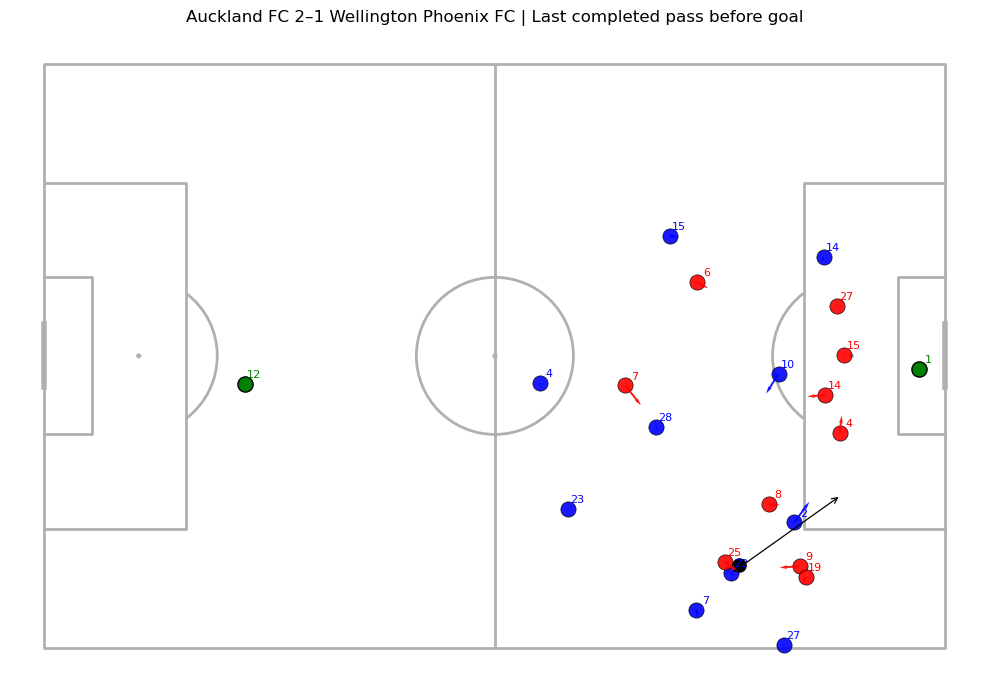

In [23]:
# 0) Legg på speed + retning først
enriched_tracking_norm = add_player_speed_direction(enriched_tracking_norm, fps=10.0)

# 1) result fra de_norm
result = get_last_completed_pass_before_all_goals(de_norm)
row = result.loc[0]

# 2) match label
ctx = match_context(match_meta_df)

# 3) plot
fig, ax = plot_tracking_frame(
    tracking_df=enriched_tracking_norm,
    selected_frame=int(row["pass_moment_frame"]),
    team_colors=TEAM_COLORS,
    gk_color=GK_COLOR,
    match_label=ctx["match_label"],
    title_prefix="Last completed pass before goal",
    ARROW=True,
    pass_x_start=float(row["pass_x_start"]),
    pass_y_start=float(row["pass_y_start"]),
    pass_x_end=float(row["pass_x_end"]),
    pass_y_end=float(row["pass_y_end"]),
    SHOW_MOVEMENT=True,          # <-- toggle
    SHOW_SPEED_LABELS=False,     # <-- toggle
    movement_scale=0.8,
    movement_min_speed=0.0,
    WORKING_DIR=PROJECT_ROOT,
    SAVE=True,
    save_name=f"{MATCH_ID}_frame_{int(row['pass_moment_frame'])}_first_goal.png",
)
plt.show()

Saved: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\opendata\viz\1899585_frame_18136_first_goal_nospeed.png


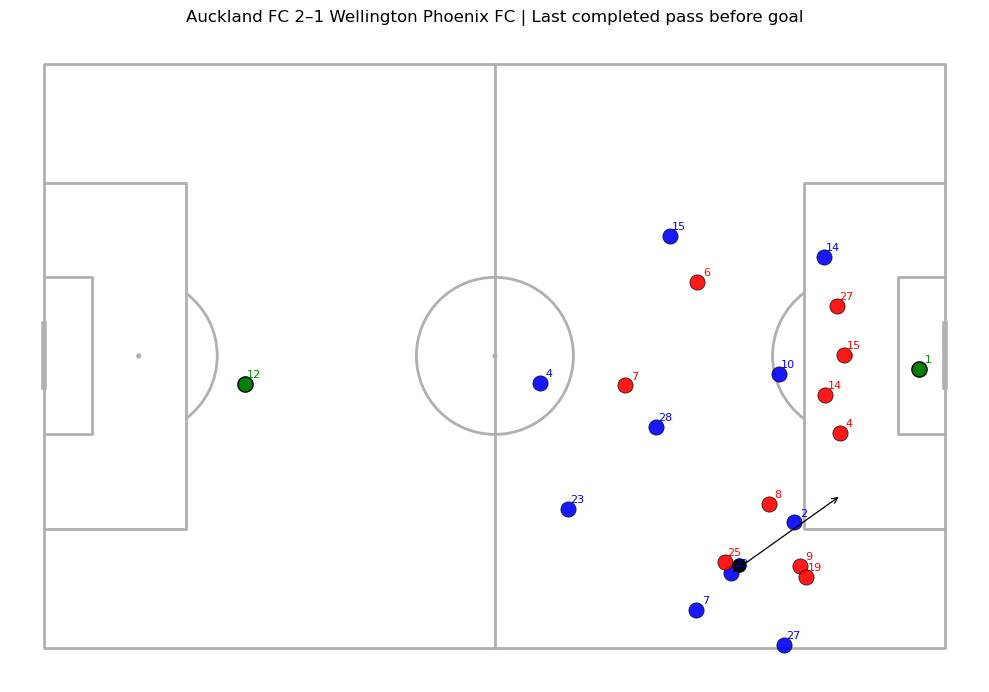

In [24]:
# 1) result fra de_norm
result = get_last_completed_pass_before_all_goals(de_norm)
row = result.loc[0]

# 2) match label
ctx = match_context(match_meta_df)

# 3) plot
fig, ax = plot_tracking_frame(
    tracking_df=enriched_tracking_norm,
    selected_frame=int(row["pass_moment_frame"]),
    team_colors=TEAM_COLORS,
    gk_color=GK_COLOR,
    match_label=ctx["match_label"],
    title_prefix="Last completed pass before goal",
    ARROW=True,
    pass_x_start=float(row["pass_x_start"]),
    pass_y_start=float(row["pass_y_start"]),
    pass_x_end=float(row["pass_x_end"]),
    pass_y_end=float(row["pass_y_end"]),
    SHOW_MOVEMENT=False,          # <-- toggle
    SHOW_SPEED_LABELS=False,     # <-- toggle
    movement_scale=0.8,
    movement_min_speed=0.0,
    WORKING_DIR=PROJECT_ROOT,
    SAVE=True,
    save_name=f"{MATCH_ID}_frame_{int(row['pass_moment_frame'])}_first_goal_nospeed.png",
)
plt.show()

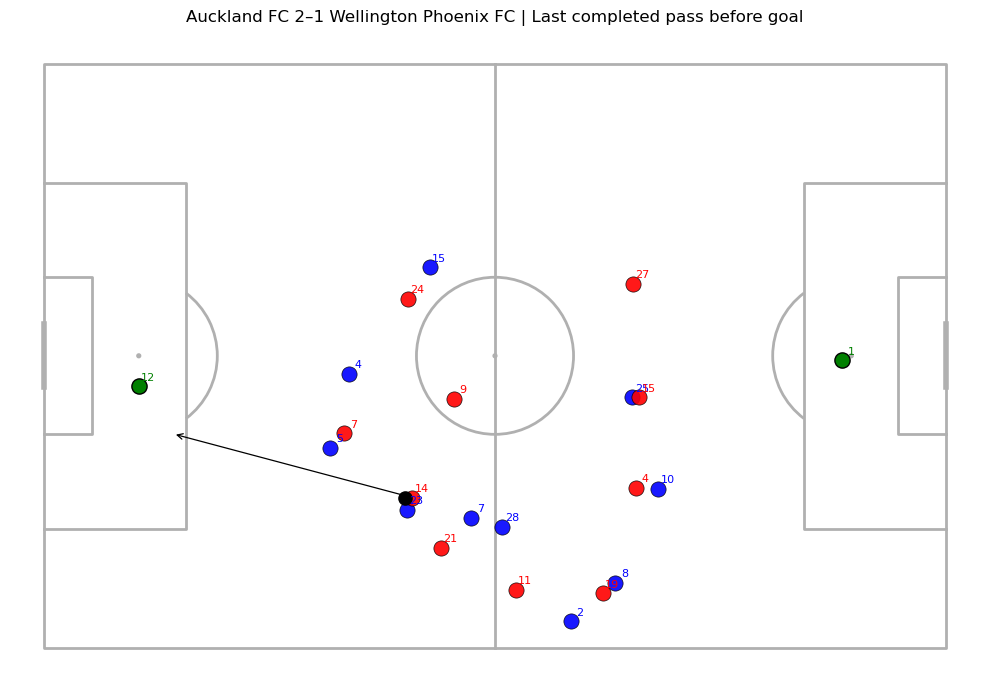

In [25]:
# 1) result fra de_norm
result = get_last_completed_pass_before_all_goals(de_norm)
row = result.loc[2]

# 2) match label
ctx = match_context(match_meta_df)

# 3) plot
fig, ax = plot_tracking_frame(
    tracking_df=enriched_tracking_norm,
    selected_frame=int(row["pass_moment_frame"]),
    team_colors=TEAM_COLORS,
    gk_color=GK_COLOR,
    match_label=ctx["match_label"],
    title_prefix="Last completed pass before goal",
    ARROW=True,
    pass_x_start=float(row["pass_x_start"]),
    pass_y_start=float(row["pass_y_start"]),
    pass_x_end=float(row["pass_x_end"]),
    pass_y_end=float(row["pass_y_end"]),
    SHOW_MOVEMENT=False,          # <-- toggle
    SHOW_SPEED_LABELS=False,     # <-- toggle
    movement_scale=0.8,
    movement_min_speed=0.0,
    WORKING_DIR=PROJECT_ROOT,
    SAVE=False,
    save_name=f"{MATCH_ID}_frame_{int(row['pass_moment_frame'])}_third_goal.png",
)
plt.show()

Saved: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\opendata\viz\1899585_frame_18136_movement.png


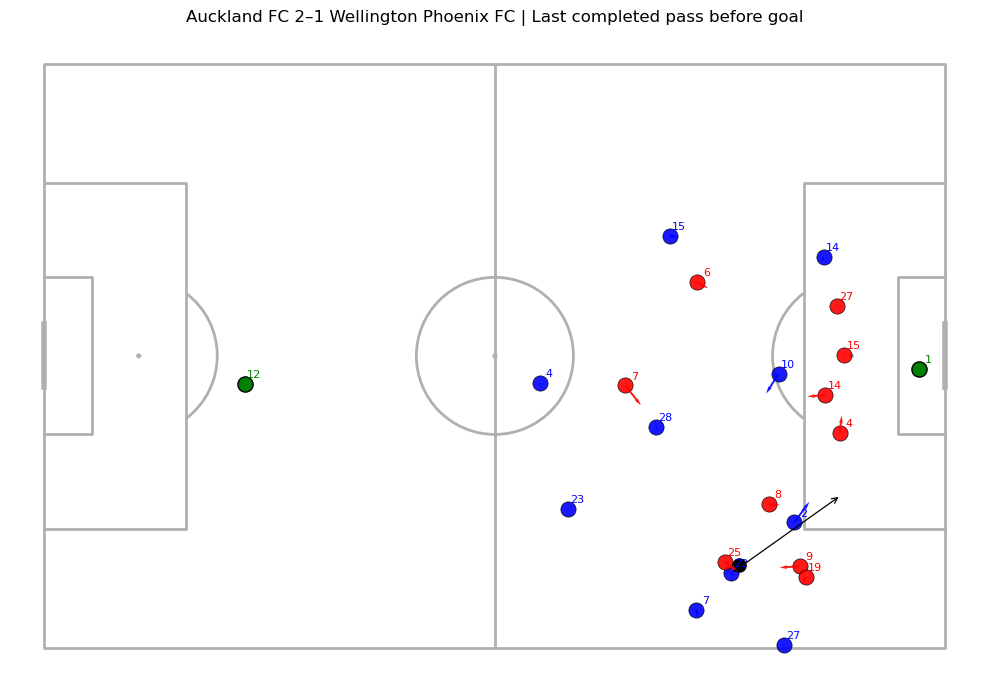

In [26]:
# 0) Legg på speed + retning først
enriched_tracking_norm = add_player_speed_direction(enriched_tracking_norm, fps=10.0)

# 1) result fra de_norm
result = get_last_completed_pass_before_all_goals(de_norm)
row = result.loc[0]

# 2) match label
ctx = match_context(match_meta_df)

# 3) plot
fig, ax = plot_tracking_frame(
    tracking_df=enriched_tracking_norm,
    selected_frame=int(row["pass_moment_frame"]),
    team_colors=TEAM_COLORS,
    gk_color=GK_COLOR,
    match_label=ctx["match_label"],
    title_prefix="Last completed pass before goal",
    ARROW=True,
    pass_x_start=float(row["pass_x_start"]),
    pass_y_start=float(row["pass_y_start"]),
    pass_x_end=float(row["pass_x_end"]),
    pass_y_end=float(row["pass_y_end"]),
    SHOW_MOVEMENT=True,          # <-- toggle
    SHOW_SPEED_LABELS=False,     # <-- toggle
    movement_scale=0.8,
    movement_min_speed=0.0,
    WORKING_DIR=PROJECT_ROOT,
    SAVE=True,
    save_name=f"{MATCH_ID}_frame_{int(row['pass_moment_frame'])}_movement.png",
)
plt.show()


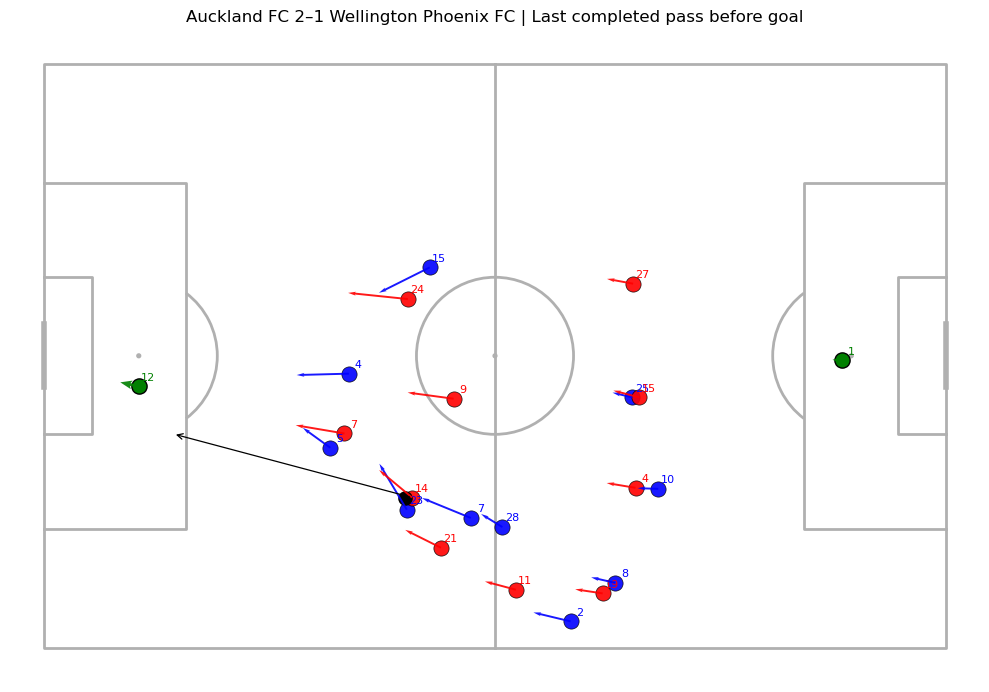

In [27]:
# 1) result fra de_norm
result = get_last_completed_pass_before_all_goals(de_norm)
row = result.loc[2]

# 2) match label
ctx = match_context(match_meta_df)

# 3) plot
fig, ax = plot_tracking_frame(
    tracking_df=enriched_tracking_norm,
    selected_frame=int(row["pass_moment_frame"]),
    team_colors=TEAM_COLORS,
    gk_color=GK_COLOR,
    match_label=ctx["match_label"],
    title_prefix="Last completed pass before goal",
    ARROW=True,
    pass_x_start=float(row["pass_x_start"]),
    pass_y_start=float(row["pass_y_start"]),
    pass_x_end=float(row["pass_x_end"]),
    pass_y_end=float(row["pass_y_end"]),
    SHOW_MOVEMENT=True,          # <-- toggle
    SHOW_SPEED_LABELS=False,     # <-- toggle
    movement_scale=0.8,
    movement_min_speed=0.0,
    WORKING_DIR=PROJECT_ROOT,
    SAVE=False,
    save_name=f"{MATCH_ID}_frame_{int(row['pass_moment_frame'])}_movement.png",
)
plt.show()

In [28]:
result

,event_id,event_type,index,player_id,frame_start,frame_end,passing_option_at_pass_moment,player_targeted_xpass_completion,n_simultaneous_passing_options,player_targeted_difficult_pass_target,...,targeted_passing_option_event_id,pass_moment_frame,pass_x_start,pass_y_start,pass_x_end,pass_y_end,goal_event_id,goal_frame_start,goal_index,goal_team_shortname
0,8_301,player_possession,1454,50951,18118,18136,NaN,0.5503,NaN,True,...,7_740,18136,27.55,-25.33,40.32,-16.25,8_302,18150,1462,Auckland FC
1,8_688,player_possession,3525,50951,43471,43476,NaN,0.9466,NaN,False,...,7_1775,43476,3.98,-21.83,7.15,-29.33,8_690,44380,3532,Auckland FC
2,8_796,player_possession,4028,51015,51849,51872,NaN,0.3655,NaN,True,...,7_2044,51872,-9.66,-16.51,-37.49,-9.10,8_797,51899,4037,Wellington P FC


In [29]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   event_id                               3 non-null      object 
 1   event_type                             3 non-null      object 
 2   index                                  3 non-null      int64  
 3   player_id                              3 non-null      int64  
 4   frame_start                            3 non-null      int64  
 5   frame_end                              3 non-null      int64  
 6   passing_option_at_pass_moment          0 non-null      float64
 7   player_targeted_xpass_completion       3 non-null      float64
 8   n_simultaneous_passing_options         0 non-null      float64
 9   player_targeted_difficult_pass_target  3 non-null      bool   
 10  player_targeted_xthreat                3 non-null      float64
 11  xpass_comp

In [30]:
from __future__ import annotations

from pathlib import Path
from typing import Optional

import imageio.v2 as imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def fig_to_rgb_array(fig: plt.Figure) -> np.ndarray:
    """Convert a Matplotlib figure to an RGB uint8 numpy array."""
    fig.canvas.draw()

    if hasattr(fig.canvas, "buffer_rgba"):
        rgba = np.asarray(fig.canvas.buffer_rgba())
        return rgba[..., :3].copy()

    if hasattr(fig.canvas, "tostring_rgb"):
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        return buf.reshape(h, w, 3)

    raise AttributeError("Cannot extract pixel buffer from this Matplotlib canvas backend.")


def make_pass_to_goal_video_mp4(
    *,
    tracking_df: pd.DataFrame,
    team_colors: dict[int, str],
    row: pd.Series,
    fps_in: int = 10,
    stride: int = 2,
    extra_seconds_before_pass: float = 1.0,
    extra_seconds_after_goal: float = 3.0,  # <-- 3 sek ekstra etter mål (default)
    freeze_seconds_before_start: float = 1.0,  # <-- 1 sek stillbilde i start (default)
    # Optional overrides
    clip_start: Optional[int] = None,
    clip_end: Optional[int] = None,
    # Plot options
    match_label: Optional[str] = None,
    title_prefix: str = "Last completed pass before goal",
    gk_color: str = "gold",
    # Output / IO
    WORKING_DIR: Optional[Path] = None,
    save_name: Optional[str] = None,
    SAVE: bool = True,
    SHOW: bool = False,
) -> Optional[Path]:
    """
    Create an MP4 clip around a pass -> goal sequence, without saving PNG frames.

    Real-time speed without all frames:
        - sample every `stride` frames
        - set output fps = fps_in / stride

    Added:
        - freeze first frame for `freeze_seconds_before_start` seconds
        - extend clip end by `extra_seconds_after_goal` seconds
    """
    if stride < 1:
        raise ValueError("stride must be >= 1")

    required_row_cols = {
        "pass_moment_frame",
        "goal_frame_start",
        "pass_x_start",
        "pass_y_start",
        "pass_x_end",
        "pass_y_end",
    }
    missing = required_row_cols.difference(row.index)
    if missing:
        raise KeyError(f"Row is missing required columns: {sorted(missing)}")

    base_dir: Path = WORKING_DIR if WORKING_DIR is not None else Path.cwd()
    out_dir: Path = base_dir / "viz" / "videos"
    out_dir.mkdir(parents=True, exist_ok=True)

    pass_frame = int(row["pass_moment_frame"])
    goal_frame = int(row["goal_frame_start"])

    if clip_start is None:
        clip_start = pass_frame - int(round(extra_seconds_before_pass * fps_in))
    if clip_end is None:
        clip_end = goal_frame + int(round(extra_seconds_after_goal * fps_in))

    min_frame = int(tracking_df["frame"].min())
    max_frame = int(tracking_df["frame"].max())
    clip_start = max(min_frame, int(clip_start))
    clip_end = min(max_frame, int(clip_end))
    if clip_end <= clip_start:
        raise ValueError(f"Invalid clip window: clip_start={clip_start}, clip_end={clip_end}")

    frame_numbers = list(range(clip_start, clip_end + 1, stride))
    fps_out = float(fps_in) / float(stride)

    if save_name is None:
        goal_id = str(row.get("goal_event_id", "goal"))
        save_name = f"pass_to_goal_{goal_id}_frames_{clip_start}_{clip_end}_s{stride}.mp4"

    out_path = out_dir / save_name

    # How many times to repeat the first frame to create a freeze
    freeze_frames = int(round(float(freeze_seconds_before_start) * fps_out))

    if SAVE:
        with imageio.get_writer(str(out_path), fps=fps_out) as writer:
            # --- 1) Render FIRST frame once, then repeat it (freeze) ---
            first_fr = frame_numbers[0]
            fig, ax = plot_tracking_frame(
                tracking_df=tracking_df,
                selected_frame=int(first_fr),
                team_colors=team_colors,
                gk_color=gk_color,
                match_label=match_label,
                title_prefix=title_prefix,
                ARROW=True,
                pass_x_start=float(row["pass_x_start"]),
                pass_y_start=float(row["pass_y_start"]),
                pass_x_end=float(row["pass_x_end"]),
                pass_y_end=float(row["pass_y_end"]),
                SAVE=False,
            )
            first_img = fig_to_rgb_array(fig)
            plt.close(fig)

            # write freeze frames
            for _ in range(max(0, freeze_frames)):
                writer.append_data(first_img)

            # --- 2) Then write the rest of the clip normally ---
            # (include first_fr too? usually no, since we already froze on it)
            for fr in frame_numbers:
                snap = tracking_df.loc[tracking_df["frame"] == int(fr)]
                if snap.empty:
                    continue

                fig, ax = plot_tracking_frame(
                    tracking_df=tracking_df,
                    selected_frame=int(fr),
                    team_colors=team_colors,
                    gk_color=gk_color,
                    match_label=match_label,
                    title_prefix=title_prefix,
                    ARROW=False,
                    pass_x_start=float(row["pass_x_start"]),
                    pass_y_start=float(row["pass_y_start"]),
                    pass_x_end=float(row["pass_x_end"]),
                    pass_y_end=float(row["pass_y_end"]),
                    SAVE=False,
                )

                img = fig_to_rgb_array(fig)
                writer.append_data(img)
                plt.close(fig)

        print(f"Saved video: {out_path}")

    if SHOW:
        try:
            from IPython.display import Video, display
            display(Video(str(out_path), embed=True))
        except Exception as e:
            print(f"[INFO] Could not display inline video. Reason: {e}")

    return out_path if SAVE else None


In [32]:
video_path = make_pass_to_goal_video_mp4(
    tracking_df=enriched_tracking_norm,
    team_colors=TEAM_COLORS,
    row=row,
    fps_in=10,
    stride=2,
    freeze_seconds_before_start=1.0,   # <-- stillbilde 1s
    extra_seconds_after_goal=3.0,      # <-- +3s etter mål
    match_label=ctx["match_label"],
    title_prefix="Last completed pass before goal",
    WORKING_DIR=PROJECT_ROOT,
    SAVE=True,
    SHOW=True,
    save_name=f"{MATCH_ID}_goal1_pass_to_goal.mp4",
)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 700) to (1008, 704) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved video: C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\opendata\viz\videos\1899585_goal1_pass_to_goal.mp4
